In [1]:
#Recreate figures in the appendix

import astropy.units as u
import numpy as np
import popsims
import matplotlib.pyplot as plt
import astropy.coordinates as astro_coord
import glob
import pandas as pd

import itertools
from scipy import stats

from popsims.plot_style import  plot_style
plot_style()

#from shapey import Box
#paths
path_plot ='../figures/'
path_data = '../data/stream/'
isochrone_path='../data/isochrones/'
path_pipeline= '../data/pipeline/'

import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import UnivariateSpline


#imorts 
import astropy.units as u
import numpy as np
#import gala.potential as gp
#import gala.dynamics as gd
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
#from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
from popsims import sample_from_powerlaw
import astropy.units as u
from tqdm import tqdm
import popsims
import pandas as pd
from easyshapey import Box
from scipy.interpolate import interp1d, griddata
from findthegap.gapper import Gapper
import torch
import itertools
#paths
import numba 
#import jax #use jax.jit instead of numba --> might change for 
#plot_style()

path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'
path_plot='../figures/'
isochrone_path=path_isochrone


In [2]:
#SOME CONSTANTS

dgrid=np.arange(0.5, 10, 0.2)
BEST_BW=0.7
#dgrid
THEORITICAL_STREAM_WIDTHS={'10_20': 0.053, '30_40': 0.094, '50_60':1.53}
GAP_SIZES={'10_20': 1.4, '30_40': 2.5, '50_60': 1.8}

In [3]:
def read_backgrounds_file(m, rgc):
    
    fls= glob.glob('../data/backgrounds/*rgc{}*maglimit{}*'.format(rgc, m))
    
    res=[]
    for f in fls:
        #print (f)
        c=np.load(f, allow_pickle=True)
        for vls in c:
            #print (vls)
            dct={}
            for k in list(vls.keys()):
                dct['dmod']=float(k.split('galaxy')[-1])
                dct['run']=f.split('run')[-1].split('.npy')[0]
                for ks in (vls[k].keys()):
                    dct[ks]=vls[k][ks]
                    
                data= vls[k]['data']
                area= (data[0].max()-data[0].min())*(data[1].max()-data[1].min())
                dct['density']= len(data[0])/area
                dct['area']=area
                dct['counts']=len(data[0])
                res.append(dct)
               
    
    return pd.DataFrame(res)

In [4]:
#functions
def show_gap_detection(vld,  GAP_SIZE, plot='None', ax=None, alpha=0.1, ms=0.1):
        #define stuff 
        meshgrid= vld['meshgrid']
        data=vld['data']
        
        grid_data = np.hstack([ xi.ravel().reshape(-1,1) for xi in meshgrid])
        
        gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'].flatten(),90 ) 
        stream_mask= vld['min_eigen'] < np.percentile(vld['min_eigen'].flatten(),15)
        
        #define weights as the density inside the stream
        #weights= 
        
        if np.isnan( vld['min_eigen']).all():
            return {}
        
        stream_size=1.0*np.nanstd(meshgrid[1][stream_mask])

        pol=np.poly1d(np.polyfit(meshgrid[0][stream_mask], meshgrid[1][stream_mask], 2))
        #pol=UnivariateSpline(meshgrid[0][stream_mask], meshgrid[1][stream_mask])


        #define stream track and gap track
        stream_track=np.abs(grid_data[:,1] - pol(grid_data[:,0]))< stream_size/2
        #redefine the stream track as a check (just a random place at 0.5 pc from the center)

        gap_center=(np.nanmedian(meshgrid[0][gap_mask]), np.nanmedian(meshgrid[1][gap_mask]))

        gap_track=np.logical_and.reduce([np.abs((grid_data[:,0]-gap_center[0])) <GAP_SIZE/2,
                                        stream_track])
        #gap_track= np.abs((grid_data[:,0]-gap_center[0])) <GAP_SIZE/2

       
        
        data_df=pd.DataFrame()
        data_df['x']=data[:,0]
        data_df['y']=data[:,1]
        
        grid_df=pd.DataFrame()
        grid_df['x']= grid_data[:,0]
        grid_df['y']= grid_data[:,1]
        
        stream_track_on_data=(np.abs(pol( data_df.x)-data_df.y)<stream_size/2).values
        gap_track_on_data=np.logical_and(np.abs((data[:,0]-gap_center[0])) <GAP_SIZE/2,  stream_track_on_data)

        nstars_stream=len( data_df[stream_track_on_data])
        nstars_bck=len( data_df[~stream_track_on_data])
        nstars_gap=len( data_df[gap_track_on_data])

        #verify
        stream_area=10*len( grid_df[stream_track])/len(grid_df)
        bck_area=10*len( grid_df[~stream_track])/len(grid_df)
        gap_area=10*len(grid_df[gap_track])/len(grid_df)
        
         #compute relevant statistics
        gap_offset=5
        try:
            gap_offset=np.nanmedian(np.abs(meshgrid[0][gap_mask]-np.nanmedian(meshgrid[0])))
        except:
            pass
        
        stats={'spread_stream_stars_x': np.nanstd(meshgrid[0][stream_mask]),
               'spread_stream_stars_y': np.nanstd(meshgrid[1][stream_mask]),
              'spread_gap_stars_x': np.nanstd(meshgrid[0][gap_mask]),
            'spread_gap_stars_y':np.nanstd(meshgrid[1][gap_mask]),
               'nstars_gap':  nstars_gap,
               'nstars_stream':  nstars_stream,
               'nstars_bck': nstars_bck,
               'stream_area': stream_area,
               'gap_area': gap_area,
               'bck_area': bck_area,
               'stream_dens':  np.divide(nstars_stream, stream_area),
               'gap_dens': np.divide(nstars_gap, gap_area),
               'bck_dens':np.divide(nstars_bck, bck_area),
               'offset_center':gap_offset,
               'gap_center': np.nanmedian(grid_data[:,0][gap_track]),
               'gap_points':grid_data[:,0][gap_track],
               'stream_center': np.nanmedian(grid_data[:,1][stream_track]),
               'stream_points':grid_data[:,1][stream_track],
               'stream_stars':data[:,1][stream_track_on_data],
               'gap_stars':data[:,0][gap_track_on_data],
              }

        if plot=='show_mask_data':
            ax.scatter(data_df.x, data_df.y,  s=ms, alpha=alpha, c='k')
            ax.scatter(data_df.x[stream_track_on_data], data_df.y[stream_track_on_data],  s=10, alpha=0.1, c='r', label='Stream')
            ax.scatter(data_df.x[gap_track_on_data], data_df.y[gap_track_on_data],  s=10, alpha=0.1, c='b', label='Gap')
        
        if plot=='show_mask_grid':
            ax.scatter(grid_df.x, grid_df.y,  s=ms, alpha=alpha, c='k')
            ax.scatter(grid_df.x[stream_track], grid_df.y[stream_track],  s=10, alpha=1, c='r', label='Stream')
            ax.scatter(grid_df.x[gap_track], grid_df.y[gap_track],  s=10, alpha=1, c='b', label='Gap')
            #ax.scatter(grid_df.x[stream_track], grid_df.y,  s=10, alpha=0.1, c='b', label='Bckgd')
        
        if plot=='plot0':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1],s=10, alpha=alpha, c='k')
            
        if plot=='plot1':

            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=1)
            #ax.scatter(grid_data[:,0], grid_data[:,1], c=res['max_eigen'].flatten(),
            #           s=1, cmap='cubehelix')

        if plot=='plot2':

            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['min_eigen'],  20, \
                              cmap='cubehelix', alpha=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            
        if plot=='plot6':
            #ax.scatter(vld['data'][:,0], vld['data'][:,1],s=0.1, alpha=0.5, c='k')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=0.5, vmin=0, vmax=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                            cmap='Greys', alpha=.1, vmin=0.0, vmax=0.2, linestyle='--')
            
            
            
        if plot=='plot4':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1],s=ms, alpha=alpha, c='k')
            ax.scatter(meshgrid[0][stream_mask], meshgrid[1][stream_mask], marker='*', s=15,c='#FF851B')
            ax.scatter(meshgrid[0][gap_mask], meshgrid[1][gap_mask], marker='*', s=15,  c='#0074D9')
            
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#FF851B', linewidth=3)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])

        if plot=='plot3':
            #verify by plotting
            #ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=alpha, c='k')
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
        if plot=='plot7':
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')
            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

            #plot gap track
            ax.scatter(np.nanmedian(grid_data[:,0][gap_track]), \
                       np.nanmax(vld['meshgrid'][1])-0.5, color='k', marker='$\u2193$', s=100)
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
            
            
        if plot=='plot5':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=0.2, c='k')
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, cmap='magma_r', alpha=0.5)

            #plot stream track
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#0074D9', linewidth=3)
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#0074D9', linewidth=3)

            #plot gap track
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
            
        if plot=='density':
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')
            p= ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')

       
        return stats


In [5]:
from popsims import sample_from_powerlaw
import scipy.interpolate as interp
path_isochrone='../data/isochrones/'
isochrone_path=path_isochrone
mag_keys=['gmag', 'imag', 'F062mag', 'F087mag']
from scipy.interpolate import interp1d, griddata

def read_orbit_file(filename):
    return np.load(path_data+'/{}'.format(filename), allow_pickle=True)

def read_stream_file(N_pal5, gap_center, box, rgc, mhalo=None, vhalo=None,  distance_to_hit=0.7):
    
    if mhalo==None:
        filename='orgininalno_self_grav_pal5_rgc{}'.format(rgc)
        f=path_streamdata+'/{}.npy'.format(filename)
        filenames=np.array(glob.glob(f))
        print (filenames)
        st=(np.load(filenames[0], allow_pickle=True).flatten()[0])['stream']

       
    else:
        filename='no_self_grav_pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}_distance_to_hit{}'.format(rgc, mhalo, vhalo, distance_to_hit )
        f=path_streamdata+'/{}.npy'.format(filename)
        filenames=np.array(glob.glob(f))
        st=(np.load(filenames[0], allow_pickle=True).flatten()[0])['stream']

        
    x0=st.y.value
    y0=st.x.value

    center=np.nanmedian(np.array(rgc.split('_')).astype(float))

    #deptermine optimal rotation angle by fitting a line to the half stream
    mask= (x0-np.nanmedian(x0))>-1
    line = np.polyfit(x0[mask], y0[mask], 1)
    angle=np.arctan(line[0])
    x0, y0=rotate(x0, y0, -angle, c=(np.nanmedian(x0), np.nanmedian(y0)))

    xshift= np.nanmedian(x0)-center
    yshift=np.nanmedian(y0)-center

    x=x0-xshift
    y=y0-yshift

    xshift=gap_center[0]
    yshift=gap_center[1]

    x=x-xshift
    y=y-yshift
    
    choose=np.random.choice(np.arange(len(x)), N_pal5)
    
    return box.select(np.array([x[choose], y[choose]]))


def count_pal5_stars_old(mag_limit, dmod):
    dmod_pal5=16.85
    cfht_mini = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
    cfht_gmag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [24])
    cfht_imag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [25])
    wfirst_mini = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
    wfirst_mags = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [23,24,25,26,27,28,29])

    sample_lowmasses=sample_from_powerlaw(-0.5, xmin=np.min(cfht_mini), xmax=np.max(cfht_mini), nsample=int(1e6)) 
    inter_gmags = interp.interp1d(cfht_mini, cfht_gmag, bounds_error=False,  fill_value=np.nan)
    inter_imags = interp.interp1d(cfht_mini, cfht_imag, bounds_error=False,  fill_value=np.nan)
    inter_Rmags = interp.interp1d(wfirst_mini, wfirst_mags[:,0], bounds_error=False,  fill_value=np.nan)
    inter_Zmags = interp.interp1d(wfirst_mini, wfirst_mags[:,1], bounds_error=False,  fill_value=np.nan)
    inter_Ymags = interp.interp1d(wfirst_mini, wfirst_mags[:,2], bounds_error=False,  fill_value=np.nan)
    inter_Jmags = interp.interp1d(wfirst_mini, wfirst_mags[:,3], bounds_error=False,  fill_value=np.nan)
    inter_Hmags = interp.interp1d(wfirst_mini, wfirst_mags[:,4], bounds_error=False,  fill_value=np.nan)
    inter_Fmags = interp.interp1d(wfirst_mini, wfirst_mags[:,5], bounds_error=False,  fill_value=np.nan)
    inter_Wmags = interp.interp1d(wfirst_mini, wfirst_mags[:,6], bounds_error=False,  fill_value=np.nan)

    if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
        print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
    else:    
        #CFHT magnitudes
        sample_gmags = inter_gmags(sample_lowmasses) +  dmod_pal5  #distance modulus Pal5
        sample_imags = inter_imags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5
        #WFIRST magnitudes
        sample_Rmags = inter_Rmags(sample_lowmasses) +  dmod_pal5  #distance modulus Pal5
        sample_Zmags = inter_Zmags(sample_lowmasses)+  dmod_pal5 #distance modulus Pal5
        sample_Ymags = inter_Ymags(sample_lowmasses)  +  dmod_pal5 
        sample_Jmags = inter_Jmags(sample_lowmasses)+  dmod_pal5  #distance modulus Pal5
        sample_Hmags = inter_Hmags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5
        sample_Fmags = inter_Fmags(sample_lowmasses)+  dmod_pal5 #distance modulus Pal5
        sample_Wmags = inter_Wmags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5
        
        #renormalize the luminosity function by computing a normalization factor
        num_20_23= len(sample_gmags[np.logical_and(sample_gmags>=20, sample_gmags<=23)])
        #print ('number of stars between 20 and 23 G mag {}'.format( num_20_23))

        norm= 3000/num_20_23
        #print (norm)
        
        #compute the difference between distance moduli and offset stars
        dist_mod_And = dmod-dmod_pal5
        #offset_Zmags= sample_Zmags+  dist_mod_And
        nstars_wfirst = (len(np.where((sample_Zmags < (mag_limit-dist_mod_And)  ))[0]))*norm
        
        #fig, ax=plt.subplots()
        #plt.scatter( sample_lowmasses, sample_gmags)
        #ax.set(ylabel=k, xlabel='Mass ')
        #j
        return nstars_wfirst
    
    
def boostrap_density_estimate(gapper_base, bw, grid_data, data, bounds, nboostrap, max_eigenvalue=True):
    ##purpose: with a gapper object, 
    #we can estimate the hessian and the maximum eigevalue by boostrapping
    #PiHPi_boots=[]
    #maxeigval_PiHPi_boots =[]
    #mineigval_PiHPi_boots =[]
    #loop over all bootstraps
    
    #@jax.jit
    def run_over_bootsraps():
        mineigval_PiHPi_boots =[]
        maxeigval_PiHPi_boots =[]
        PiHPi_boots=[]
        for i in range(nboostrap):
            #boot_indx = np.random.choice(np.arange(data.shape[0]), data.shape[0], 
            #                         replace=True) ## Sample with replacement:bootstrap
            idx = np.random.randint(len(data), size=len(data))
            boot=data[idx,:]
            gapper_ = Gapper(data[idx, :], bw, bounds)
            PiHPis_grid = []
            eigval_PiHPi = [] 

            for pt in grid_data:
                _pihpi = gapper_.get_PiHPi(pt) 
                #_pihpi_eigval, _ =  jax.numpy.linalg.eigh(jax.numpy.array(_pihpi)) #np.linalg.eigh(_pihpi)
                #print (_pihpi_eigval)
                #print (np.array(jax.numpy.asarray(_pihpi_eigval)))
                #print (type(_pihpi_eigval))
                _pihpi_eigval, _= np.linalg.eigh(_pihpi)
                PiHPis_grid.append(_pihpi)
                eigval_PiHPi.append(_pihpi_eigval)
                #print (eigval_PiHPi)

            PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
        
            #option for using minium or maximum eigenvalue
            #if max_eigenvalue:
            max_eigval_PiHPi_k = np.nanmax(eigval_PiHPi, axis=1)
            #rescale everything between 0 and 1
            max_eigval_PiHPi_k = (max_eigval_PiHPi_k-np.nanmin(max_eigval_PiHPi_k))/(np.nanmax(max_eigval_PiHPi_k)-np.nanmin(max_eigval_PiHPi_k))

            #if not max_eigenvalue:
            min_eigval_PiHPi_k = np.nanmin(eigval_PiHPi, axis=1)
            min_eigval_PiHPi_k = (min_eigval_PiHPi_k-np.nanmin(min_eigval_PiHPi_k))/(np.nanmax(min_eigval_PiHPi_k)-np.nanmin(min_eigval_PiHPi_k))


            maxeigval_PiHPi_boots.append(max_eigval_PiHPi_k)
            mineigval_PiHPi_boots.append(min_eigval_PiHPi_k)

            PiHPi_boots.append(PiHPis_grid)
        #print(f'Run {i} finished')
        return np.array(maxeigval_PiHPi_boots), np.array(mineigval_PiHPi_boots), np.array(PiHPi_boots)
    return run_over_bootsraps()


def find_gaps(bw, data, nboostrap=5, padding=0.5):
    n= 50
    bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])
    x_to_y= np.ptp(data[:,0])/ np.ptp(data[:,1])
    gridding_size = [ n,int( n/(x_to_y))]
    grid_linspace = [ np.linspace(bounds[d][0]+padding, bounds[d][1]-padding, gridding_size[d]) for d in range(2) ]
    meshgrid = np.meshgrid(*grid_linspace, indexing='ij')

    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
    grid_data = np.hstack(meshgrid_ravel)

    gapper_base = Gapper(data, bw, bounds)
    grid_density = gapper_base.kde.score_samples(torch.tensor(grid_data))
    density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))

    #compute piHpi matrix by bootstraping
    maxeigval_PiHPi_boots,  mineigval_PiHPi_boots, PiHPi_boots = boostrap_density_estimate(gapper_base, bw,\
                                                                   grid_data, data, bounds, nboostrap,\
                                                                   max_eigenvalue=True)
    
    #visualize and take the median
    maxeigval_PiHPi_boots = np.array(maxeigval_PiHPi_boots)
    mineigval_PiHPi_boots = np.array(mineigval_PiHPi_boots)
    
    #median
    med_maxeigval_pihpi = np.median(maxeigval_PiHPi_boots, axis=0)
    med_maxeigval_pihpi_resh = med_maxeigval_pihpi.reshape((gridding_size[0], gridding_size[1]))

    med_mineigval_pihpi = np.median(mineigval_PiHPi_boots, axis=0)
    med_mineigval_pihpi_resh = med_mineigval_pihpi.reshape((gridding_size[0], gridding_size[1]))

    return  {'density': np.array(density_matr), \
              'max_eigen':np.array(med_maxeigval_pihpi_resh),
              'min_eigen':np.array(med_mineigval_pihpi_resh),
              'meshgrid':np.array(meshgrid), 
              'PiHPi': np.array(PiHPi_boots),
              'data': np.array(data)}

def count_pal5_stars(mag_limit, dmod):
    dmod_pal5=16.85
    def read_pandas_isochrones():
        from astropy.io import ascii
        return ascii.read(path_isochrone+'/cfht_pre2014_isochrones_pal5.txt').to_pandas()

    def read_roman_isochrones():
        from astropy.io import ascii
        return ascii.read(path_isochrone+'/roman_isochrones_vega_pal5.txt').to_pandas()
    
    nsample=1e6
    masses= sample_from_powerlaw(-.5, xmin=0.1, xmax=120, nsample=nsample)
    cfht=read_pandas_isochrones()
    roman= read_roman_isochrones()
    comb= pd.concat([cfht, roman]).reset_index()
    
    
    isos={}
    for k in mag_keys:
        x= np.log10(comb.Mini.values)
        y=comb[k].values
        nans=np.logical_or(np.isnan(x), np.isnan(y))
        isos['mass']= masses
        #f=griddata(x[~nans], y[~nans], np.log10(masses) , fill_value=np.nan, method='linear', rescale=True)
        sort=np.argsort(x[~nans])
        f=interp1d(x[~nans][sort], y[~nans][sort], fill_value =np.nan, bounds_error=False)(np.log10(masses))
        isos.update({k: f+dmod_pal5})
    
    df=pd.DataFrame(isos)
    
    num_20_23= len(df.gmag.values[np.logical_and(df.gmag.values>=20, df.gmag.values<=23)])
    norm= (3000/num_20_23)
    
    #compute the difference between distance moduli and offset stars
    dist_mod_And = dmod- dmod_pal5
    
    return len(df.F087mag.values[df.F087mag.values<(mag_limit-dist_mod_And)])*norm

def make_box(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    return b

def rotate(x, y, ang, c=(0,0)):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],
       [np.sin(ang), np.cos(ang)]]
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 

In [6]:
#intact stream 
d=0.8*u.Mpc
rgc='10_20'
mag_limit=28.69
d_galaxy=d.to(u.kpc)
dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
kpc_conversion = np.pi * d_galaxy / 180.
roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)

bckgds= read_backgrounds_file(mag_limit, rgc)

In [7]:
def read_backgrounds_file_full_roman_fov(mag_limit, rgc, box, dmod):
    folder= '../data/mockbackgrounds/'
    filename='rgc{}dmod{:.2f}mlimit{:.2f}'.format(rgc, dmod, mag_limit)
    df=pd.read_csv(folder+filename)
    
    #print (df.columns)
    #metacllitcut cuts
    df=(df[df.MH<-1])
    vls=[df.x_coord.values, df.y_coord.values]
    
    return box.select(np.array(vls))

In [8]:
DATA={}
center=np.nanmedian(np.array(rgc.split('_')).astype(float))
b=make_box( (center, center), 15, 15)
#vls_bck=read_backgrounds_file_full_roman_fov(28.69, rgc, b, dmod_galaxy)
vls_bkc=read_backgrounds_file(28.69, '10_20')
vls_bck=np.vstack(vls_bkc[vls_bkc.dmod==np.round(dmod_galaxy, 2)].sample(n=1).data.values)

N_pal5=int(count_pal5_stars_old(mag_limit, dmod_galaxy))
vls=read_stream_file(N_pal5, (2, 0.2), b, rgc)

DATA.update({'bckgd':{'data': vls_bck, 'pipeline_res': {}}})

conct=np.array([np.concatenate([vls[0], vls_bck[0]]),\
    np.concatenate([vls[1], vls_bck[1]])])

DATA.update({'stream':{'data':conct, 'pipeline_res': {}}})
#offcentered stream 
center=np.nanmedian(np.array(rgc.split('_')).astype(float))
b=make_box( (center, center), roman_fov.value, roman_fov.value)

dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
N_pal5=int(count_pal5_stars_old(mag_limit, dmod_galaxy))

vls=read_stream_file(N_pal5, (3., 0.), b, rgc, mhalo=5e6, vhalo=-50,  distance_to_hit=0.5)

conct=np.array([np.concatenate([vls[0], vls_bck[0]]),\
    np.concatenate([vls[1]-0.5, vls_bck[1]])])

DATA.update({'streamgap':{'data':conct, 'pipeline_res': {}}})

['../data/stream//orgininalno_self_grav_pal5_rgc10_20.npy']


In [9]:
N_pal5

1508

In [10]:
#fig, ax=plt.subplots()
#ax.scatter(DATA['stream']['data'][0], DATA['stream']['data'][1], s=0.1, c='k')
#ax.scatter(DATA['streamgap']['data'][0], DATA['streamgap']['data'][1], s=0.1, c='k')

In [11]:
#np.save('/users/caganze/streams_data.npy',  DATA, allow_pickle=True)

In [12]:
DATA['streamgap']['data']

array([[15.50441497, 14.94171714, 13.77770001, ..., 13.86483785,
        15.36105044, 11.80081148],
       [14.83552861, 14.91235033, 14.93487105, ..., 13.83539997,
        16.62459125, 16.06876206]])

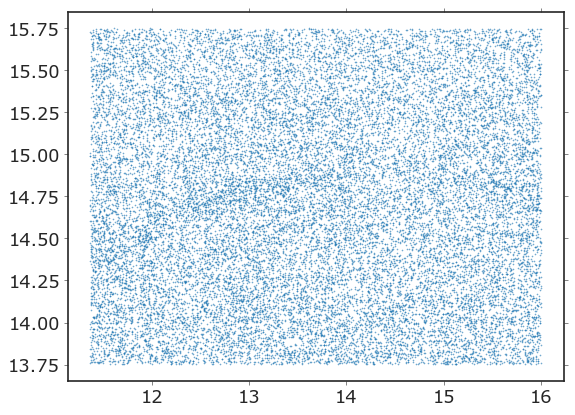

In [13]:
fig, ax=plt.subplots()
b=make_box( (13.5, 14.75), 5, 2)
s=b.select(DATA['streamgap']['data'])
ax.scatter(s[0], s[1], s=.1)

In [14]:
res=find_gaps(0.7, s.T, nboostrap=10, padding=0.0)

In [15]:
import matplotlib as mpl

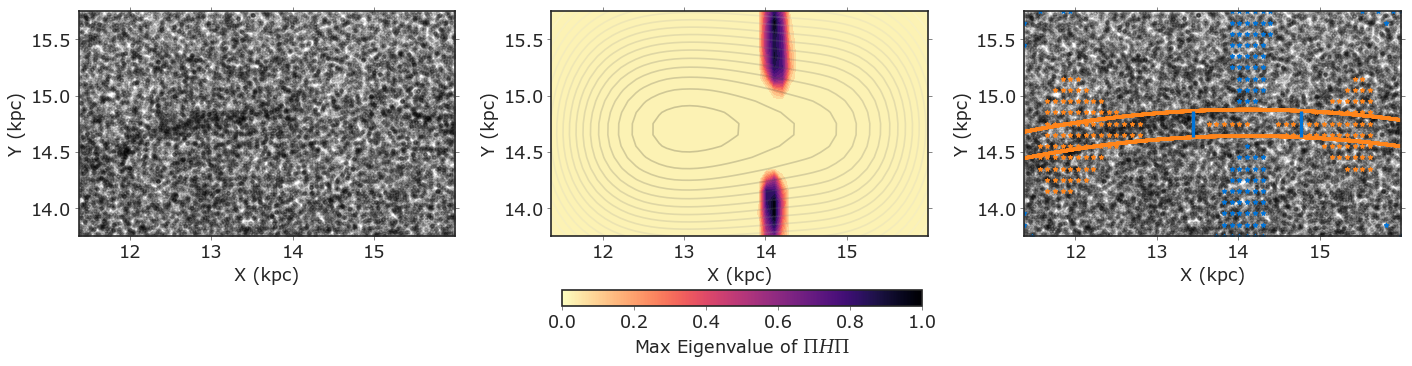

In [16]:
fig, ax=plt.subplots(figsize=(18,4), ncols=3)

meshgrid=res['meshgrid']

ax[0].scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax[0].set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)

_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot1', ax=ax[1])
#_= show_gap_detection(res,  plot='plot4', ax=ax[-1])


cmap = mpl.cm.magma_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([.4, -0.0, 0.25, 0.05])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')

_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot4', ax=ax[-1], alpha=0.12, ms=10)

for a in ax:
    a.set(xlabel='X (kpc)', ylabel='Y (kpc)')
plt.tight_layout()
plt.savefig('../figures/appendix_offcenter{:.2f}.jpeg'.format(mag_limit), bbox_inches='tight')

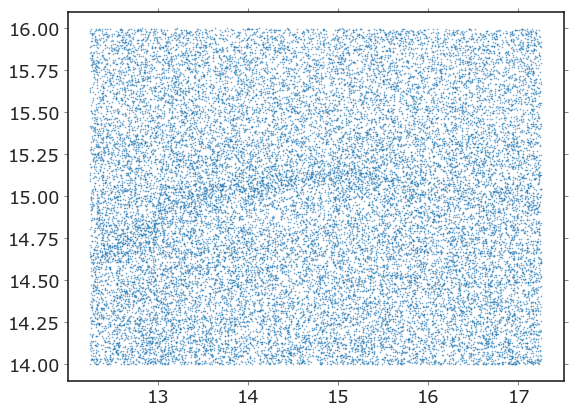

In [17]:
fig, ax=plt.subplots()
b=make_box( (14.75, 15), 5, 2)
s=b.select(DATA['stream']['data'])
ax.scatter(s[0], s[1], s=.1)

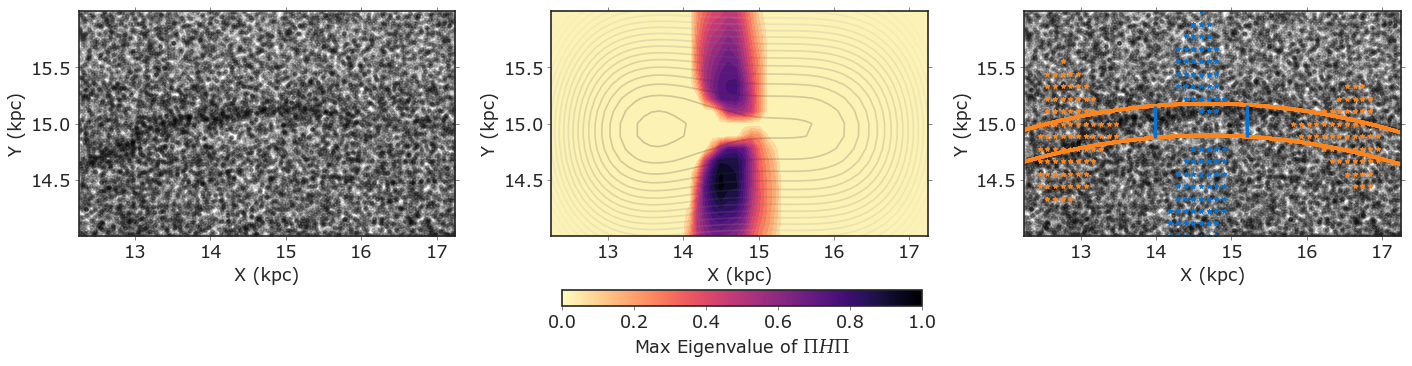

In [18]:
res=find_gaps(0.7, s.T, nboostrap=10, padding=0.0)
fig, ax=plt.subplots(figsize=(18,4), ncols=3)

meshgrid=res['meshgrid']

ax[0].scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax[0].set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)

_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot1', ax=ax[1])
#_= show_gap_detection(res,  plot='plot4', ax=ax[-1])


cmap = mpl.cm.magma_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([.4, -0.0, 0.25, 0.05])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')

_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot4', ax=ax[-1], alpha=0.12, ms=10)

for a in ax:
    a.set(xlabel='X (kpc)', ylabel='Y (kpc)')
plt.tight_layout()
plt.savefig('../figures/appendix_intact{:.2f}.jpeg'.format(mag_limit), bbox_inches='tight')

In [19]:
'appendix_offcenter{:.2f}.jpeg'.format(mag_limit)

'appendix_offcenter28.69.jpeg'

In [20]:
'appendix_intact{:.2f}.jpeg'.format(mag_limit)

'appendix_intact28.69.jpeg'